# IMPORT MODULES

In [1]:
import numpy as np
np.random.seed(13)
import torch
torch.manual_seed(21)
import matplotlib.pyplot as plt
import warnings
from mlcvs.utils.data import create_time_lagged_dataset, FastTensorDataLoader
from torch.utils.data import Subset,random_split
from mlcvs.utils.io import load_dataframe
warnings.filterwarnings('ignore')
from mlcvs.tica import DeepTICA_CV

import pandas

### plot functions

In [2]:
#-- plot model loss function --#
def plot_model_lossfunction(model):

    n_eig=len(model.nn[-1].bias)

    fig, axs = plt.subplots(1,2,figsize=(12,5))#,dpi=100)

    loss_train = [x.cpu() for x in model.loss_train]
    loss_valid = [x.cpu() for x in model.loss_valid]

    # Loss function
    ax = axs[0]
    ax.plot(loss_train,'-',label='Train')
    ax.plot(loss_valid,'--',label='Valid')
    ax.set_ylabel('Loss Function')

    # Eigenvalues vs epoch
    ax = axs[1]
    with torch.no_grad():
        evals_train = np.asarray(torch.cat(model.evals_train).cpu())
    for i in range(n_eig):
        ax.plot(evals_train[:,i],label='Eig. '+str(i+1))
    ax.set_ylabel('Eigenvalues')
    
    # Common setup
    for ax in axs:
        if model.earlystopping_.best_epoch is not None:
            if model.earlystopping_.early_stop:
                ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
                ax.set_xlabel('#Epochs')
                ax.legend(ncol=2)

    plt.tight_layout()

<AxesSubplot:xlabel='phi', ylabel='psi'>

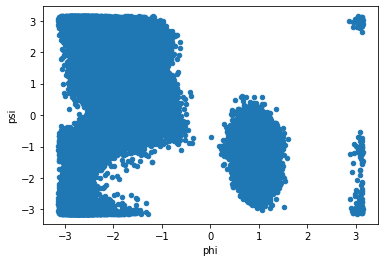

In [4]:
#-- COLVAR: 50 MB --#
path = "COLVAR"
data = load_dataframe(path)
data.plot.scatter(x="phi",y="psi")

In [5]:
%%time
temp,kb = 300,0.008314
beta = 1/ (kb * temp)
lag_time = 10
X, t, logweights = data.filter(regex="^d[^a-z]").values, data['time'].values, (data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy()) )*beta

dataset = create_time_lagged_dataset(X,t=t,lag_time=lag_time,logweights=logweights)

x_t,x_lag,w_t,w_lag = dataset[:][0],dataset[:][1],dataset[:][2],dataset[:][3] 

CPU times: user 53.3 s, sys: 440 ms, total: 53.7 s
Wall time: 48.7 s


In [6]:
#-- to run process from jupyter --#
import subprocess
import os
from pathlib import Path
# execute bash command in the given folder
def execute(command, folder, background=False, print_result=True):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True, close_fds=background)
    if cmd.returncode == 0:
        if print_result:
            print(f'Completed: {command}')
    else:
        print(cmd.stderr)

In [10]:
%%time
#-- compile cpp, longest procedure --#
execute("make",folder=".")
#-- remove old files
execute("rm w_lag.txt w_t.txt x_lag.txt x_t.txt",folder=".", print_result=False)

#-- write input file to create time lagged dataset --#
names = load_dataframe(path).filter(regex="^d[^a-z]").columns
first_index = data.columns.get_loc(names[0])
last_index = data.columns.get_loc(names[-1])
weights_index = data.columns.get_loc("opes.bias")
skip = 4 #skip the first four rows after the header 
# colvar = <COLVAR filename>
# temp = <temperature>
# lag = <lag time>
# first_index = <first index column of the descriptors in COLVAR>
# last_index = <last index column of the descriptors in COLVAR>
# if_weights = <0 or 1, in order to use or not the rescaled time>
# weights_index = <column index in COLVAR for logweights >
with open("input.dat","w") as file:
    print("""colvar = """+path+"""
skip_rows = """+str(skip)+"""
beta = """+str(beta)+"""
lag = """+str(lag_time)+"""
first_index = """+str(first_index)+"""
last_index = """+str(last_index)+"""
if_weights = 1
weights_index = """+str(weights_index)+"""
""",file=file)
!cat input.dat

Index(['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11',
       'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21',
       'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31',
       'd32', 'd33', 'd34', 'd35', 'd36', 'd37', 'd38', 'd39', 'd40', 'd41',
       'd42', 'd43', 'd44', 'd45'],
      dtype='object')
colvar = COLVAR
skip_rows = 4
beta = 0.4009301579664822
lag = 10
first_index = 4
last_index = 48
if_weights = 1
weights_index = 51

CPU times: user 478 ms, sys: 39.9 ms, total: 517 ms
Wall time: 705 ms


In [11]:
%%time
#-- run create_time_lagged_dataset.exe --#
execute("./create_time_lagged_dataset.exe input.dat",folder=".")

#--load data with pandas, much faster than numpy --#
cpp_xt = torch.Tensor(pandas.read_csv("x_t.txt",delimiter="\t",dtype=float,header=None).to_numpy())
cpp_xlag = torch.Tensor(pandas.read_csv("x_lag.txt",delimiter="\t",dtype=float,header=None).to_numpy())
cpp_wt = torch.Tensor( np.transpose( pandas.read_csv("w_t.txt",delimiter="\t",dtype=float,header=None).to_numpy() )[0] )
cpp_wlag = torch.Tensor( np.transpose( pandas.read_csv("w_lag.txt",delimiter="\t",dtype=float,header=None).to_numpy() )[0] )

#-- create TensorDataset for training --#
data = cpp_xt,cpp_xlag,cpp_wt,cpp_wlag
dataset_cpp = torch.utils.data.TensorDataset(*data)

Completed: ./create_time_lagged_dataset.exe input.dat
CPU times: user 9.97 s, sys: 450 ms, total: 10.4 s
Wall time: 9.51 s


In [12]:
print(w_lag[:].shape)
print(cpp_wlag[:].shape)
print(w_lag[:])
print(cpp_wlag[:])

torch.Size([199510])
torch.Size([399870])
tensor([0.0759, 0.0170, 0.0929,  ..., 0.4570, 0.0273, 0.6484])
tensor([0.0759, 0.0170, 0.0929,  ..., 0.4550, 0.0265, 0.6509])


# Test Training
## python version

In [13]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',
              'lag_time':1,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              #if reweight the timescale
              "reweighting": True,
              }
#--------------------------------------#

In [14]:
torch.manual_seed(21)
n_train  = int( 0.7 * len(dataset) )
n_valid  = len(dataset) - n_train
train_data, valid_data = random_split(dataset,[n_train,n_valid])

# create dataloaders
train_loader = FastTensorDataLoader(train_data, batch_size=len(train_data))
valid_loader = FastTensorDataLoader(valid_data, batch_size=len(valid_data))

print('Time-lagged pairs:\t',len(dataset))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'])
model.to(device)

# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])

# REGULARIZATION
model.set_optimizer(opt)
model.set_earlystopping(patience=train_parameters['es_patience'],
                        min_delta=0.,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False)

# TRAIN
model.fit(train_loader,valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])

Time-lagged pairs:	 199510
Training data:		 139657
Validation data:	 59853
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.949      -0.958      0.952  -0.003 
100   -0.967      -0.971      0.964  0.003  
150   -0.988      -0.986      0.977  0.011  
200   -1.000      -0.994      0.982  0.017  
250   -1.004      -0.995      0.985  0.019  
300   -1.007      -0.997      0.987  0.020  
INFO: Early stopping
321   -1.008      -0.997      0.988  0.020  


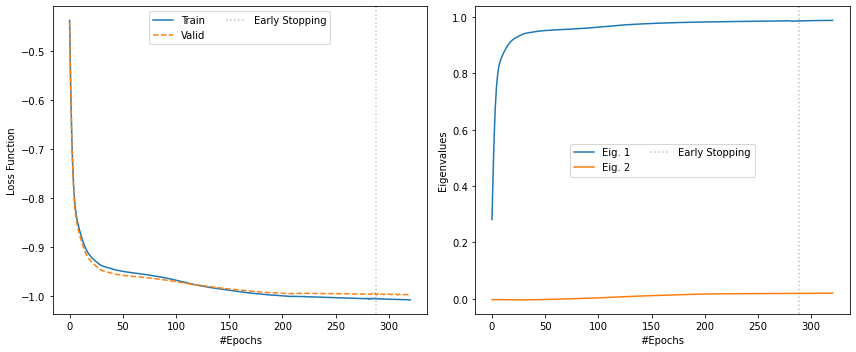

In [15]:
model.to("cpu")
plot_model_lossfunction(model)

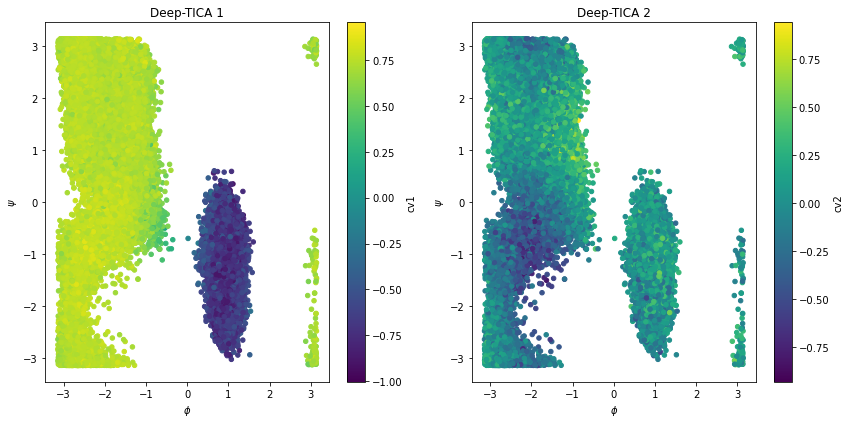

In [18]:
data = load_dataframe(path)
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

## CPP Training

In [19]:
torch.manual_seed(21)
n_train  = int( 0.7 * len(dataset_cpp) )
n_valid  = len(dataset_cpp) - n_train
train_data, valid_data = random_split(dataset_cpp,[n_train,n_valid])

# create dataloaders
train_loader = FastTensorDataLoader(train_data, batch_size=len(train_data))
valid_loader = FastTensorDataLoader(valid_data, batch_size=len(valid_data))

print('Time-lagged pairs:\t',len(dataset_cpp))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model_cpp = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'])
model_cpp.to(device)

# OPTIMIZER (Adam)
opt = torch.optim.Adam(model_cpp.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])

# REGULARIZATION
model_cpp.set_optimizer(opt)
model_cpp.set_earlystopping(patience=train_parameters['es_patience'],
                        min_delta=0.,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False)

# TRAIN
model_cpp.fit(train_loader,valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])

Time-lagged pairs:	 399870
Training data:		 279909
Validation data:	 119961
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.969      -0.961      0.953  0.015  
100   -0.988      -0.980      0.968  0.019  
150   -1.002      -0.993      0.980  0.021  
200   -1.008      -0.998      0.983  0.024  
250   -1.012      -0.999      0.985  0.028  
INFO: Early stopping
278   -1.020      -1.004      0.985  0.030  


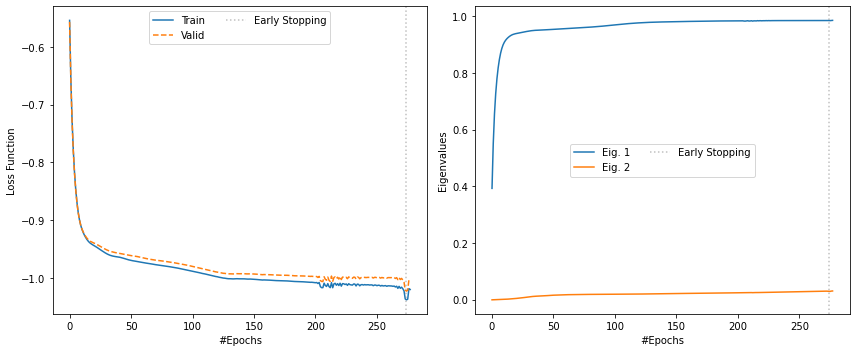

In [20]:
model_cpp.to("cpu")
plot_model_lossfunction(model_cpp)

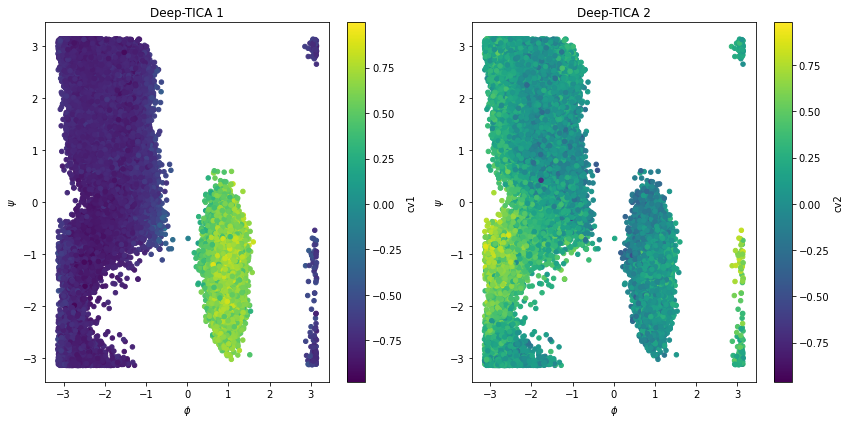

In [21]:
data = load_dataframe(path)
data["cv1"] = np.transpose(model_cpp(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model_cpp(torch.Tensor(X)).detach().cpu().numpy())[1]

fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

# Time Auto-Correlation 

In [22]:
def create_time_lagged_dataset_cpp(input_file):

    #-- remove old files --#
    execute("rm w_lag.txt w_t.txt x_lag.txt x_t.txt",folder=".", print_result=False)

    #-- run create_time_lagged_dataset.exe --#
    execute("./create_time_lagged_dataset.exe "+input_file,folder=".", print_result=False)

    #--load data with pandas, much faster than numpy --#
    cpp_xt = torch.Tensor(pandas.read_csv("x_t.txt",delimiter="\t",dtype=float,header=None).to_numpy())
    cpp_xlag = torch.Tensor(pandas.read_csv("x_lag.txt",delimiter="\t",dtype=float,header=None).to_numpy())
    cpp_wt = torch.Tensor( np.transpose( pandas.read_csv("w_t.txt",delimiter="\t",dtype=float,header=None).to_numpy() )[0] )
    cpp_wlag = torch.Tensor( np.transpose( pandas.read_csv("w_lag.txt",delimiter="\t",dtype=float,header=None).to_numpy() )[0] )

    #-- create TensorDataset for training --#
    data = cpp_xt,cpp_xlag,cpp_wt,cpp_wlag
    dataset = torch.utils.data.TensorDataset(*data)

    return dataset

In [23]:
#-- My Autocorrelation --#
def my_autocorrelation_python(x,lag,weight=None,time=None):
   
    N = len(x)
    if weight is None:
        weight = np.ones(N)
    if time is None:
        time = np.arange(0,N)

    data = create_time_lagged_dataset(x, t = time, lag_time = lag, logweights = np.log(weight))
    x_t,x_lag,w_t,w_lag = np.array(data[:][0]),np.array(data[:][1]),np.array(data[:][2]),np.array(data[:][3])
    Nw = np.sum(w_t)
    mean = np.average(x_t,weights=w_t)
    variance = np.cov(x_t,aweights=w_t)
    autocorr = np.sum( np.multiply( np.multiply( (x_t-mean), (x_lag-mean) ), w_lag ) ) / (Nw*variance)

    return autocorr

#-- index tells me which is the descriptor to analyze --#
def my_autocorrelation_cpp(inputFile,lag,index,weight=True):
    
    #-- modify lag time in input file --#
    execute("sed -i 's/lag.*/lag = "+str(lag)+"/g' "+inputFile,folder=".", print_result=False)

    #-- modify if_weight in input file --#
    if not weight:
        execute("sed -i 's/if_weights.*/if_weights = 0/g' "+inputFile,folder=".", print_result=False)
    else:
        execute("sed -i 's/if_weights.*/if_weights = 1/g' "+inputFile,folder=".", print_result=False)

    #-- ricordo che i weights vengono moltiplicati per beta dentro la funzione cpp --#
    data = create_time_lagged_dataset_cpp(inputFile)
    x_t,x_lag,w_t,w_lag = np.array(data[:][0]).T[index],np.array(data[:][1]).T[index],np.array(data[:][2]),np.array(data[:][3])
    Nw = np.sum(w_t)
    mean = np.average(x_t,weights=w_t)
    variance = np.cov(x_t,aweights=w_t)
    autocorr = np.sum( np.multiply( np.multiply( (x_t-mean), (x_lag-mean) ), w_lag ) ) / (Nw*variance)

    return autocorr

In [26]:
##-- phi statistics --#
x = load_dataframe(path).filter(regex="^d10").to_numpy()
N = len(x)
x = x.reshape(N)
weight= np.exp(np.transpose( load_dataframe(path).filter(regex="^opes.bias$").to_numpy() )[0]/temp)

average = np.average(x,weights=weight)
variance = np.cov(x,aweights=weight)
print("average: ",average, ", variance: ",variance)

average:  0.12210962555958621 , variance:  9.292651506345895e-06


# Time autocorrelation python and Cpp and Pandas Autocorr 
## no weights

In [27]:
%%time
x = np.transpose(load_dataframe(path).filter(regex="^d10").to_numpy()[:])[0]
time = np.transpose(load_dataframe(path).filter(regex="^time").to_numpy()[:])[0]
#weight= np.exp(np.transpose( load_dataframe(path).filter(regex="^opes.bias$").to_numpy()[:] )[0]/temp)
autocorr = np.empty(0)
weight = None
for k in range(50):
    res = my_autocorrelation_python(x,lag=k,weight=weight,time=time)
    autocorr = np.append(autocorr,res)

CPU times: user 48min 1s, sys: 10.5 s, total: 48min 12s
Wall time: 43min 14s


In [28]:
%%time
autocorr_cpp = np.empty(0)
for k in range(50):
    res = my_autocorrelation_cpp("input.dat",lag=k,index=9,weight=False)
    autocorr_cpp = np.append(autocorr_cpp,res)

CPU times: user 10min 37s, sys: 42.9 s, total: 11min 20s
Wall time: 4min 23s


In [29]:
%%time
x = load_dataframe(path).filter(regex="^d10")
autocorr_pd = np.empty(0)
for k in range(50):
    res = x["d10"].autocorr(k)
    autocorr_pd = np.append(autocorr_pd,res)

CPU times: user 341 ms, sys: 16 ms, total: 357 ms
Wall time: 355 ms


## plot

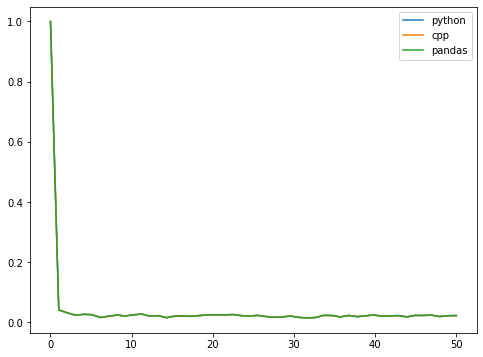

In [30]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.linspace(0,50,50),autocorr,label="python")
ax.plot(np.linspace(0,50,50),autocorr_cpp,label="cpp")
ax.plot(np.linspace(0,50,50),autocorr_pd,label="pandas")
ax.legend()

## with weights

In [31]:
%%time
x = np.transpose(load_dataframe(path).filter(regex="^d10").to_numpy()[:])[0]
time = np.transpose(load_dataframe(path).filter(regex="^time").to_numpy()[:])[0]
weight= np.exp(np.transpose( load_dataframe(path).filter(regex="^opes.bias$").to_numpy()[:] )[0]/temp)
autocorr = np.empty(0)
for k in range(10):
    res = my_autocorrelation_python(x,lag=k,weight=weight,time=time)
    autocorr = np.append(autocorr,res)

CPU times: user 4min 13s, sys: 2.02 s, total: 4min 15s
Wall time: 3min 35s


In [32]:
%%time
autocorr_cpp = np.empty(0)
for k in range(10):
    res = my_autocorrelation_cpp("input.dat",lag=k,index=9,weight=True)
    autocorr_cpp = np.append(autocorr_cpp,res)

CPU times: user 1min 31s, sys: 8.93 s, total: 1min 39s
Wall time: 1min 36s


# Plot

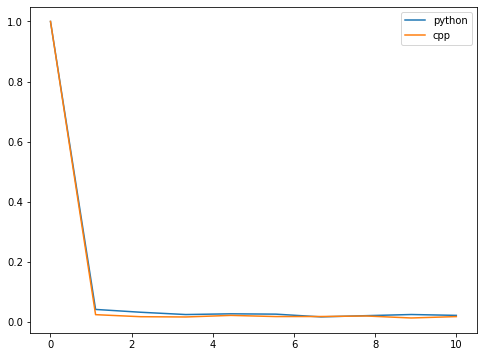

In [33]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.linspace(0,10,10),autocorr,label="python")
ax.plot(np.linspace(0,10,10),autocorr_cpp,label="cpp")
ax.legend()